<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/02_download_metro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.8 MB/s eta 0:00:00


In [12]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm

## Download OSM Data

In [39]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

In [25]:
%%time
# city = 'Dehli_NCR'
metro_stops = []
metro_lines = []

for city, bbox in tqdm(bboxs.items(), unit=' cities'):

    ## Download OSM data
    W,S,E,N = bboxs[city]
    public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'railway':True}).reset_index()
    public_transport['city'] = city
    # print("Length of the dataframe" , public_transport.shape[0])

    ## Extract Metro Stops
    stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['railway']=='station')].copy()
    stops['city'] = city
    # print(f"Number of stations: {stops.shape[0]} in {city}")

    ## Extract Metro Lines
    lines = public_transport.loc[(public_transport['railway'].notna()) & (public_transport['name'].notna())].copy()
    # print(f"Number of lines: {lines.shape[0]} in {city}")

    metro_lines.append(lines)
    metro_stops.append(stops)

100%|██████████| 7/7 [00:05<00:00,  1.28 cities/s]

CPU times: user 5.08 s, sys: 112 ms, total: 5.2 s
Wall time: 5.47 s


In [26]:
metro_line_df = pd.concat(metro_lines)
metro_station_df = pd.concat(metro_stops)

print(metro_line_df.shape, metro_station_df.shape)

(6153, 265) (846, 265)


In [43]:
station_columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'name:mr', 'network', 'operator', 'public_transport',
       'ref', 'train']

<Axes: >

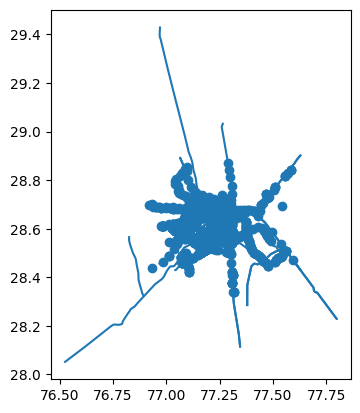

In [40]:
metro_line_df[metro_line_df['city']=="Dehli_NCR"].plot()

In [10]:
%%time
## Download OSM data
city = "Mumbai"
W,S,E,N = bboxs[city]
public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'subway':True, 'public_transport': 'station', 'railway':'subway'}).reset_index()
print(public_transport.shape)

(590, 98)
CPU times: user 534 ms, sys: 1.01 ms, total: 535 ms
Wall time: 560 ms


Number of stations: 261


<Axes: >

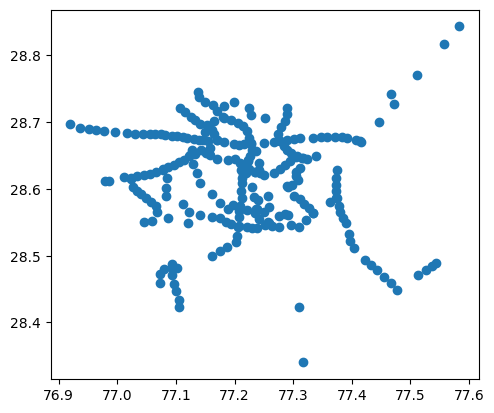

In [ ]:
metro_stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['subway']=='yes') & (public_transport['public_transport']=='station')]
print(f"Number of stations: {metro_stops.shape[0]}")
metro_stops.plot()

In [ ]:
bus_stops = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'public_transport': 'station'}).reset_index()
bus_stops[bus_stops['subway']!='yes'].to_csv('bus_stops.csv')

Number of lines: 477


<Axes: >

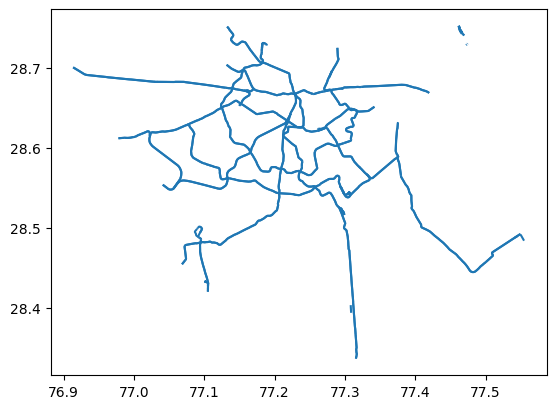

In [ ]:
metro_lines = public_transport.loc[(public_transport['railway']=='subway') & (public_transport['name'].notna())]
print(f"Number of lines: {metro_lines.shape[0]}")
metro_lines.plot()

In [ ]:
metro_lines.to_parquet(f'{}_metro_lines.parquet')
metro_stops.to_parquet(f'{}_metro_stops.parquet')